# Kalman filter implementation

We are given the state space model

\begin{equation}
\begin{array}{rclll}
x_{t+1} & = & A_{o}x_{t}+Cw_{t+1} & \qquad n\times 1 & \qquad w_{t+1}\sim
N\left( 0,I_{p}\right)  \\
y_{t} & = & Gx_{t}+v_{t} & \qquad m\times 1 & \qquad v_{t}\sim N\left(
0,R\right) .%
\end{array}
\end{equation}

Here, $x_{t}$ is an unobservable state vector that follows a Gaussian Markov
process, $y_{t}$, is a measurement vector and $v_{t}$ is measurement noise
independent of $\left\{ w_{t}\right\} _{t=1}^{\infty }$. We assume an
initial condition

\begin{equation}
x_{0}\sim N\left( \hat{x}_{0},\Sigma _{0}\right) \text{.}
\end{equation}

The Kalman (1960) filtering algorithm leads to a recursive formula for
the best predictor of $x_{t}$ given observations $y^{t-1}=\left(
y_{t-1},\ldots ,y_{0}\right) $. Because of the linear-Gaussian structure of
the whole system, we can infer that the predictor will also be Gaussian, so
it is sufficient to construct predictors for the first two moments of its
distribution

\begin{align}
\hat{x}_{t} &=E\left[ x_{t}\mid y^{t-1}\right] \\
\Sigma _{t} &=E\left[ \left( x_{t}-\hat{x}_{t}\right) \left( x_{t}-\hat{x}%
_{t}\right) ^{\prime }\right] .  
\end{align}

The solution in the form of an innovations representation is given by the system of equations

\begin{align}
a_{t} &=y_{t}-G\hat{x}_{t} \\
K_{t} &=A_{o}\Sigma _{t}G^{\prime }\left( G\Sigma _{t}G^{\prime }+R\right)
^{-1} \\
\hat{x}_{t+1} &=A_{o}\hat{x}_{t}+K_{t}a_{t}  \\
\Sigma _{t+1} &=\left( A_{o}-K_{t}G\right) \Sigma _{t}\left(
A_{o}-K_{t}G\right) ^{\prime }+CC^{\prime }+K_{t}RK_{t}^{\prime } 
\end{align}

and, for a sequence of data $y_t$, $t = 0,1,\ldots,T-1$, yields the path $\hat{x}_t$, $\Sigma_t$, $t=1,\ldots,T$.

## Implementation

We now apply the Kalman filter model to the following problem. Let $x_t$ represents the productivity of the economy that follows a scalar AR(1) process:

\begin{equation}
x_{t+1} = A_o x_t + C w_{t+1}.
\end{equation}

We do not observe productivity but we do measure GDP, which represents a noisy measurement of the true underlying productivity

\begin{equation}
y_t = G x_t + v_t \qquad v_t \sim N(0,R)
\end{equation}

We want to construct the best estimate $\hat{x}_t$ and the associated variance of the estimate $\Sigma_t$ for the underlying productivity.

We will vary the parameters $A_o$, $C$, $G$, $R$ of the model to study the impact these parameters have on the resulting estimated path $x_t$.

How do we determine these parameters in practice? One possibility is that they are determined inside a macroeconomic model that describes how actual GDP in the economy can fluctuate around its productivity. Another possibility is to stay agnostic about the macroeconomic model, and estimate these parameters jointly with the path $\hat{x}_t$. This is a standard problem in time-series econometrics, which we will leave aside.

Define the local folder where graphs will be stored, and from which data will be retrieved. If you are running the notebook within Google Colab, use the second option.

In [1]:
graphfolder = "graphs/"
datafolder = "data/"

# options for Google Colab (uncomment the following lines)
# graphfolder = "gdrive/MyDrive/graphs/"
# datafolder = "gdrive/MyDrive/data/"

Import relevant packages.

In [2]:
# render graphs within notebook
%matplotlib inline

# import packages
import numpy as np
#import requests
#import pandas as pd
#import pandas_datareader as pdr
#from io import BytesIO
#from scipy import stats
#from scipy import optimize

# load econutil package with some frequently used functions
import econutil as ec

Root package econutil imported.


We first write a function that takes as input the model parameters, the prior parameters, and data $y_t$, $t=0,1,\ldots,T-1$ and produces the filtered path $\hat{x}_t$ and variance $\Sigma_t$, $t=1,\ldots,T$.

In [3]:
def Kalman_filter(model,y):
    # model: model parameters in matrix form
    # data: m x T matrix of data, one vector of observations in each column
    Ao,C,G,R = model["Ao"],model["C"],model["G"],model["R"]
    m,T,n,p = y.shape[0], y.shape[1], C.shape[0], C.shape[1]
    
    xhat, Sigmahat = np.empty([n,T+1]), np.empty([n,n,T+1])
    xhat[:,0] = model["x0hat"]
    Sigmahat[:,:,0] = model["Sigma0hat"]
    
    for t in range(T):
        a = y[:,t] - G*xhat[:,t]
        K = Ao*Sigmahat[:,:,t]*G.transpose()*np.linalg.inv(G*Sigmahat[:,:,t]*G.transpose() + R)
        xhat[:,t+1] = Ao*xhat[:,t] + K*a
        Sigmahat[:,:,t+1] = (Ao-K*G)*Sigmahat[:,:,t]*(Ao-K*G).transpose()  + C*C.transpose() + K*R*K.transpose()
    
    return xhat, Sigmahat

Load GDP data from FRED.

In [4]:
# myLoadDataFRED uses the pandas_reader.data.Reader function to download time series from FRED
data_Y = ec.LoadDataFRED(series=['GDPC1'],transform='none')
data = 4*np.asmatrix(np.log(data_Y['GDPC1'][1:]) - np.log(data_Y['GDPC1'][:-1]))
data = data - data.mean()
data_year = data_Y["year"][1:]

Run alternative models.

In [5]:
# baseline model parameters
model = {}
model["Ao"],model["C"],model["G"],model["R"] = np.asmatrix(0.98),np.asmatrix(0.02),np.asmatrix(1),np.asmatrix(0.05**2)
model["x0hat"],model["Sigma0hat"] = 0, 0.1**2

# run the benchmark model
model_benchmark = model.copy()
xhat_benchmark,Sigmahat_benchmark = Kalman_filter(model,data)

# lower persistence of the state
# adjusting volatility of shocks of the hidden state so that unconditional volatility stays the same
Aonew = 0.25
Cnew = model['C'] * np.power(((1-Aonew**2)/(1-model['Ao']**2)),0.5)
model["Ao"],model["C"] = Aonew,Cnew
xhat_less_pers,Sigmahat_less_pers = Kalman_filter(model,data)

# more noise in the signal
model = model_benchmark.copy()
model["R"] = 0.15**2
xhat_more_noise,Sigmahat_more_noise = Kalman_filter(model,data)

Plot data and the resulting estimated paths $x_t$ for alternative model specifications.

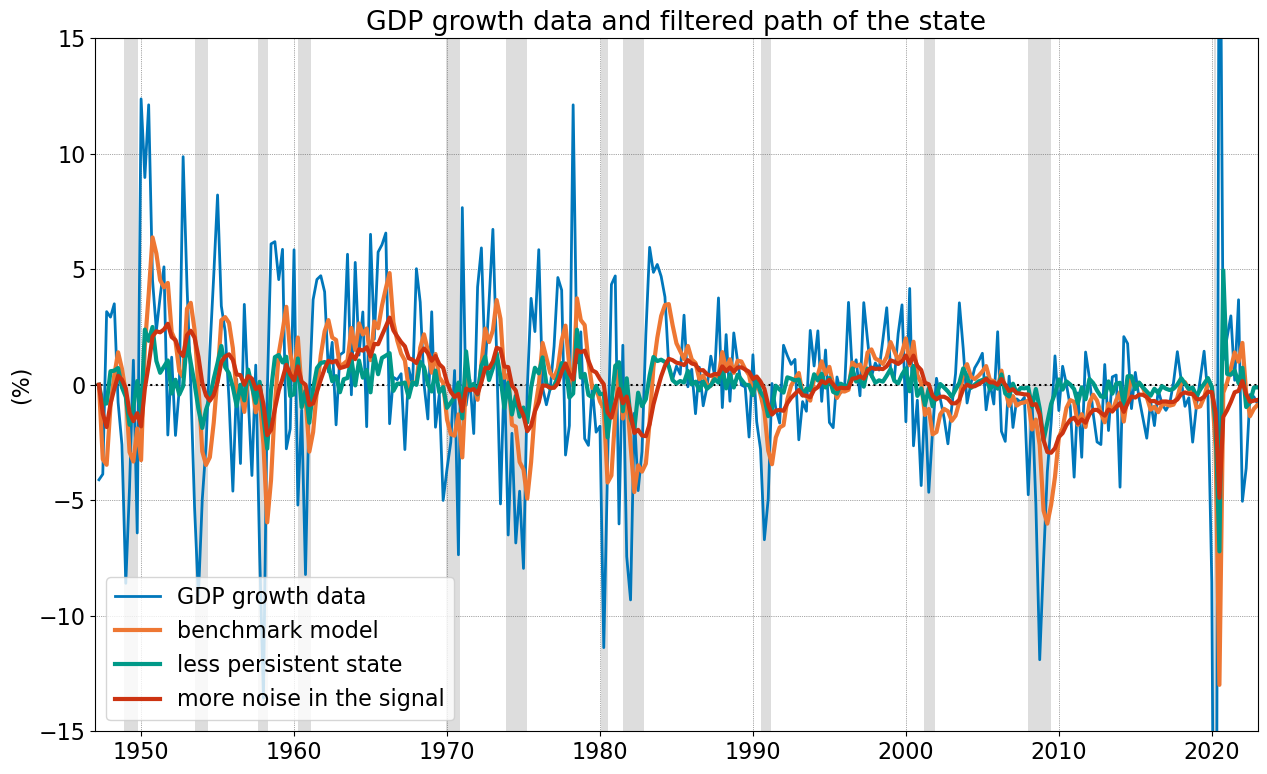

In [6]:
fig_param = {'figsize' : [15,9], 'fontsize': 16, 'subplots': [1,1],
         'title': 'GDP growth data and filtered path of the state',
         'xlim': [1947,2023], 'ylim': [-15,15],
         'xlabel': '', 'ylabel': '(%)',
         'ylogscale': False,
         'showgrid': True, 'highlightzero': True,
         'showNBERrecessions' : True, 'showNBERrecessions_y': [-30,30]}
    
fig,ax = ec.GenerateTSPlot(fig_param)

ax.plot(data_year.transpose(),data[0,:].transpose()*100,
            linewidth=2,color=ec.tolColor['tolVibrantBlue'],label='GDP growth data')
ax.plot(data_year,np.matrix.flatten(xhat_benchmark[:,:-1])*100,
            linewidth=3,color=ec.tolColor['tolVibrantOrange'],label='benchmark model')
ax.plot(data_year,np.matrix.flatten(xhat_less_pers[:,:-1])*100,
            linewidth=3,color=ec.tolColor['tolVibrantTeal'],label='less persistent state')
ax.plot(data_year,np.matrix.flatten(xhat_more_noise[:,:-1])*100,
            linewidth=3,color=ec.tolColor['tolVibrantRed'],label='more noise in the signal')

x = ax.legend(loc="lower left")

fig.set_facecolor('#FFFFFF')
fig.savefig(graphfolder + '/filtering_gdp_path.pdf',bbox_inches='tight')

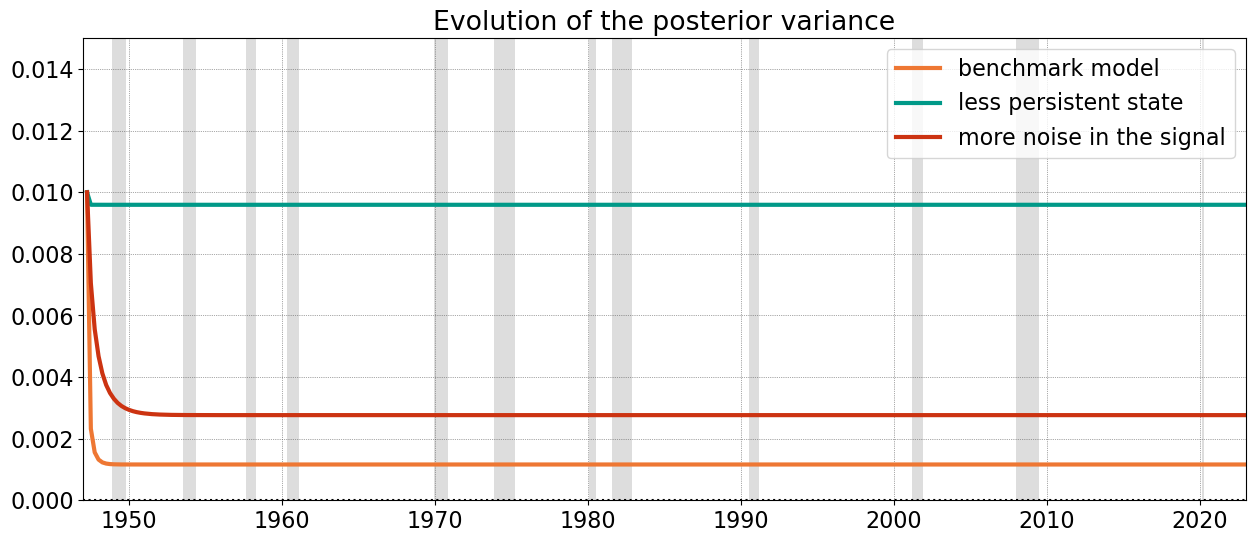

In [7]:
fig_param = {'figsize' : [15,6], 'fontsize': 16, 'subplots': [1,1],
         'title': 'Evolution of the posterior variance',
         'xlim': [1947,2023], 'ylim': [0,0.015],
         'xlabel': '', 'ylabel': '',
         'ylogscale': False,
         'showgrid': True, 'highlightzero': True,
         'showNBERrecessions' : True, 'showNBERrecessions_y': [-30,30]}
    
fig,ax = ec.GenerateTSPlot(fig_param)

ax.plot(data_year,np.matrix.flatten(Sigmahat_benchmark[:,:,:-1]),
            linewidth=3,color=ec.tolColor['tolVibrantOrange'],label='benchmark model')
ax.plot(data_year,np.matrix.flatten(Sigmahat_less_pers[:,:,:-1]),
            linewidth=3,color=ec.tolColor['tolVibrantTeal'],label='less persistent state')
ax.plot(data_year,np.matrix.flatten(Sigmahat_more_noise[:,:,:-1]),
            linewidth=3,color=ec.tolColor['tolVibrantRed'],label='more noise in the signal')

x = ax.legend(loc="upper right")

fig.set_facecolor('#FFFFFF')
fig.savefig(graphfolder + '/filtering_gdp_variance.pdf',bbox_inches='tight')